<a href="https://colab.research.google.com/github/UlisesToledoH/sqlite-pandas-utils/blob/main/DashboardVentas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dashboard de ventas con JOINs y pandas

In [1]:
import sqlite3 as db
import pandas as pd

In [2]:
conexion = db.connect("DataDash.db")
cursor = conexion.cursor()

In [4]:
#Tablas

cursor.execute("""
    CREATE TABLE IF NOT EXISTS Clientes(
        ClienteID INTEGER PRIMARY KEY AUTOINCREMENT,
        Nombre TEXT NOT NULL,
        Apellido TEXT NOT NULL,
        Tel INT NOT NULL
    )
""")

cursor.execute("""
    CREATE TABLE IF NOT EXISTS Productos(
        ProductoID INTEGER PRIMARY KEY AUTOINCREMENT,
        Nombre TEXT NOT NULL,
        categoria TEXT NOT NULL,
        Precio REAL NOT NULL
    )

""")

cursor.execute("""
  CREATE TABLE IF NOT EXISTS Ventas(
    id_venta integer primary key,
    id_cliente integer,
    id_producto integer,
    fecha_venta date,
    cantidad integer,
    FOREIGN KEY (id_cliente) REFERENCES Clientes(ClienteID),
    FOREIGN KEY (id_producto) REFERENCES Productos(ProductoID)
  )

""")

In [44]:
from random import randint, choice
from datetime import datetime, timedelta


In [60]:
cursor.execute("DELETE FROM clientes")
cursor.execute("DELETE FROM productos")
cursor.execute("DELETE FROM ventas")
conexion.commit()


In [62]:
# Clientes más completos
clientes = [
    (1, "Ulises", "Toledo", 879021435),
    (2, "Ana", "Arenas", 1078943),
    (3, "Cane", "Cua", 178904323),
    (4, "Lalo", "Ramos", 567890234),
    (5, "Nadia", "Meza", 978456123)
]

# Más productos y categorías
productos = [
    (1, "Laptop", "Tecnología", 15000),
    (2, "Mouse", "Accesorios", 300),
    (3, "Monitor", "Tecnología", 4000),
    (4, "Teclado", "Accesorios", 500),
    (5, "Audífonos", "Audio", 1200),
    (6, "Webcam", "Accesorios", 900),
    (7, "Tablet", "Tecnología", 8000)
]

# Ventas aleatorias en junio 2024 (30 días, 100 ventas)
ventas = []
fecha_inicio = datetime(2024, 6, 1)
id_venta = 1

for _ in range(100):
    id_cliente = randint(1, 5)
    id_producto = randint(1, 7)
    cantidad = randint(1, 3)
    fecha = (fecha_inicio + timedelta(days=randint(0, 29))).strftime("%Y-%m-%d")
    ventas.append((id_venta, id_cliente, id_producto, fecha, cantidad))
    id_venta += 1

cursor.executemany("INSERT INTO clientes VALUES (?, ?, ?, ?)", clientes)
cursor.executemany("INSERT INTO productos VALUES (?, ?, ?, ?)", productos)
cursor.executemany("INSERT INTO ventas VALUES (?, ?, ?, ?, ?)", ventas)

conexion.commit()


In [63]:
consulta = pd.read_sql_query("""
SELECT
    v.fecha_venta,
    c.nombre AS cliente,
    p.nombre AS producto,
    p.categoria,
    v.cantidad,
    p.precio,
    (v.cantidad * p.precio) AS total
FROM
    Ventas v
JOIN Clientes c ON v.id_cliente = c.CLIENTEID
JOIN Productos p ON v.id_producto = p.PRODUCTOID
""", conexion)

consulta



,fecha_venta,cliente,producto,categoria,cantidad,Precio,total
0,2024-06-26,Nadia,Webcam,Accesorios,1,900.0,900.0
1,2024-06-27,Cane,Teclado,Accesorios,2,500.0,1000.0
2,2024-06-14,Nadia,Teclado,Accesorios,2,500.0,1000.0
3,2024-06-23,Ana,Tablet,Tecnología,2,8000.0,16000.0
4,2024-06-25,Cane,Audífonos,Audio,1,1200.0,1200.0
...,...,...,...,...,...,...,...
95,2024-06-13,Ulises,Laptop,Tecnología,2,15000.0,30000.0
96,2024-06-09,Ulises,Webcam,Accesorios,3,900.0,2700.0
97,2024-06-25,Ulises,Audífonos,Audio,2,1200.0,2400.0
98,2024-06-13,Nadia,Teclado,Accesorios,3,500.0,1500.0


Dashboard con pandas

In [65]:
print("Ventas totales por categoria")
print(consulta.groupby("categoria")["total"].sum())

print("Totales por cliente")
print(consulta.groupby("cliente")["total"].sum())

print("Prod mas vendido")
print(consulta.groupby("producto")["cantidad"].sum().sort_values(ascending=False))

Ventas totales por categoria
categoria
Accesorios     65700.0
Audio          43200.0
Tecnología    505000.0
Name: total, dtype: float64
Totales por cliente
cliente
Ana       112100.0
Cane      152200.0
Lalo      117000.0
Nadia     124700.0
Ulises    107900.0
Name: total, dtype: float64
Prod mas vendido
producto
Webcam       48
Audífonos    36
Teclado      33
Monitor      28
Tablet       21
Mouse        20
Laptop       15
Name: cantidad, dtype: int64


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

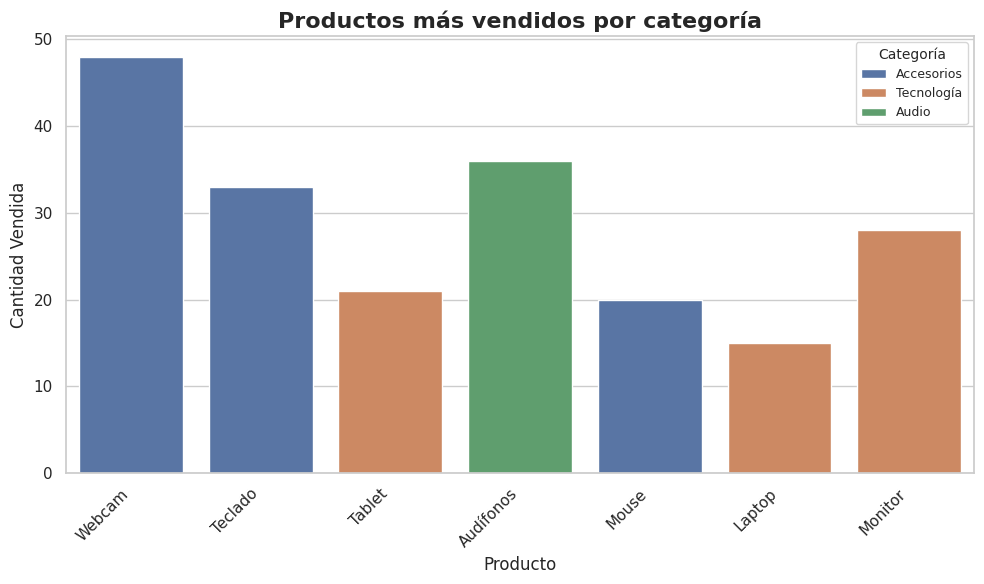

In [71]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))  # Tamaño del gráfico


sns.barplot(
    data=consulta,            # DataFrame
    x="producto",             # Eje X
    y="cantidad",             # Eje Y
    hue="categoria",          # Color por categoría (opcional)
    estimator=sum,
    errorbar=None,            # Desactiva líneas de error
    palette="deep"           # Paleta de colores (puedes usar "dark", "pastel", "deep", etc.)
)

# Título y etiquetas
plt.title("Productos más vendidos por categoría", fontsize=16, weight='bold')
plt.xlabel("Producto", fontsize=12)
plt.ylabel("Cantidad Vendida", fontsize=12)

# Rotación para legibilidad
plt.xticks(rotation=45, ha='right')

# Leyenda (opcional si usas `hue`)
plt.legend(title="Categoría", title_fontsize=10, fontsize=9)

# Espaciado automático
plt.tight_layout()

plt.show()